<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/007_TensorFlow_Proj_Seven_CNN_MNIST_FashionMNIST_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preprocess

In [ ]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow import one_hot
from tensorflow.config import list_physical_devices, experimental
from tensorflow.keras import Model, Sequential, layers, callbacks, applications, optimizers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.utils import plot_model, to_categorical, image_dataset_from_directory
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, AUC

In [ ]:
physical_devices = list_physical_devices("GPU")
experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### MNISt Date Base

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
print("x_train:", x_train.shape, type(x_train))
print("y_train:", y_train.shape, type(y_train))
print("x_test:", x_test.shape, type(x_test))
print("y_test:", y_test.shape, type(y_test))

x_train: (60000, 28, 28) <class 'numpy.ndarray'>
y_train: (60000,) <class 'numpy.ndarray'>
x_test: (10000, 28, 28) <class 'numpy.ndarray'>
y_test: (10000,) <class 'numpy.ndarray'>


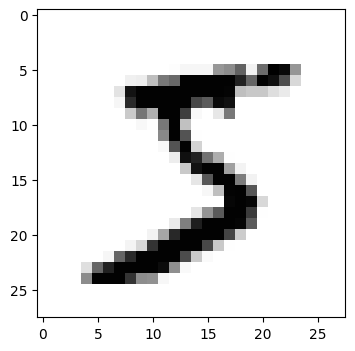

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(x_train[0], cmap="Greys")
plt.show()

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

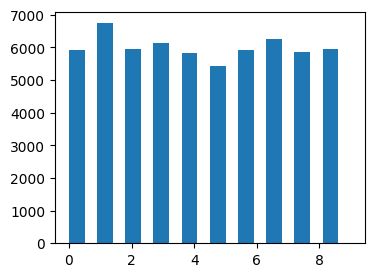

In [ ]:
plt.figure(figsize=(4,3))
plt.hist(y_train, bins=10, width=0.5)

(array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
        1009.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

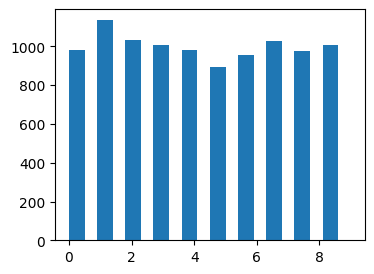

In [ ]:
plt.figure(figsize=(4,3))
plt.hist(y_test, bins=10, width=0.5)

In [ ]:
def ConvNet_builder():
  inputs = layers.Input(shape=(x_train.shape[1],x_train.shape[2],1), name="input_layer")
  feature = layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="valid",
                          activation="relu", name="first_conv_layer")(inputs)
  feature = layers.MaxPool2D(pool_size=(2,2), name="first_pool_layer")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="valid",
                          activation="relu", name="second_conv_layer")(feature)
  feature = layers.MaxPool2D(pool_size=(2,2), name="second_pool_layer")(feature)
  feature = layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="valid",
                          activation="relu", name="third_conv_layer")(feature)
  feature = layers.Flatten(name="flatten_layer")(feature)
  feature = layers.Dense(units=64, activation="relu", name="first_dense_layer")(feature)
  outputs = layers.Dense(units=10, activation="softmax", name="output_layer")(feature)
  model = Model(inputs=inputs, outputs=outputs, name="cnn_arc")
  model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
model = ConvNet_builder()
model.summary()

Model: "cnn_arc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 first_conv_layer (Conv2D)   (None, 26, 26, 32)        320       
                                                                 
 first_pool_layer (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 second_conv_layer (Conv2D)  (None, 11, 11, 64)        18496     
                                                                 
 second_pool_layer (MaxPool  (None, 5, 5, 64)          0         
 ing2D)                                                          
                                                                 
 third_conv_layer (Conv2D)   (None, 3, 3, 32)          1846

In [ ]:
model_callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto'),
                   callbacks.ModelCheckpoint(filepath="mnist_cnn.h5",save_best_only=True, monitor="val_loss")]
history = model.fit(x=x_train, y=y_train, validation_split=0.2, epochs=30,
                    batch_size=64, callbacks=[model_callbacks])

Epoch 1/30
750/750 [==============================] - 17s 6ms/step - loss: 0.4328 - accuracy: 0.9133 - val_loss: 0.0922 - val_accuracy: 0.9764
Epoch 2/30
 39/750 [>.............................] - ETA: 2s - loss: 0.0743 - accuracy: 0.9792

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 3s 4ms/step - loss: 0.0745 - accuracy: 0.9784 - val_loss: 0.0730 - val_accuracy: 0.9796
Epoch 3/30
750/750 [==============================] - 3s 4ms/step - loss: 0.0544 - accuracy: 0.9844 - val_loss: 0.0613 - val_accuracy: 0.9838
Epoch 4/30
750/750 [==============================] - 6s 8ms/step - loss: 0.0425 - accuracy: 0.9878 - val_loss: 0.0902 - val_accuracy: 0.9813
Epoch 5/30
750/750 [==============================] - 6s 9ms/step - loss: 0.0363 - accuracy: 0.9898 - val_loss: 0.0542 - val_accuracy: 0.9858
Epoch 6/30
750/750 [==============================] - 6s 8ms/step - loss: 0.0321 - accuracy: 0.9909 - val_loss: 0.0643 - val_accuracy: 0.9862
Epoch 7/30
750/750 [==============================] - 4s 5ms/step - loss: 0.0285 - accuracy: 0.9925 - val_loss: 0.0730 - val_accuracy: 0.9873
Epoch 8/30
750/750 [==============================] - 3s 4ms/step - loss: 0.0265 - accuracy: 0.9929 - val_loss: 0.0713 - val_accuracy: 0.9861
Epoch 9/30
750/75

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.1009 - accuracy: 0.9894


[0.10093296319246292, 0.9894000291824341]

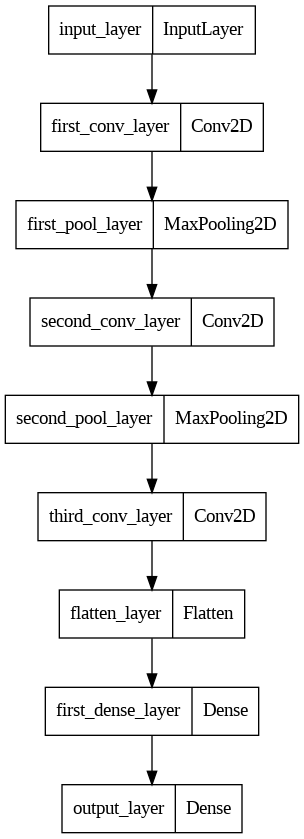

In [ ]:
plot_model(model)

In [ ]:
print(model.metrics_names)

['loss', 'accuracy']


In [ ]:
metrics = pd.DataFrame(history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.432795,0.913250,0.092185,0.976417
1,0.074532,0.978396,0.072993,0.979583
2,0.054366,0.984438,0.061318,0.983833
3,0.042493,0.987792,0.090233,0.981333
4,0.036330,0.989812,0.054188,0.985750
5,0.032114,0.990937,0.064304,0.986167
6,0.028504,0.992500,0.073045,0.987333
7,0.026520,0.992896,0.071308,0.986083
8,0.023640,0.993833,0.073535,0.987000
9,0.020239,0.994583,0.094978,0.986583


NameError: ignored

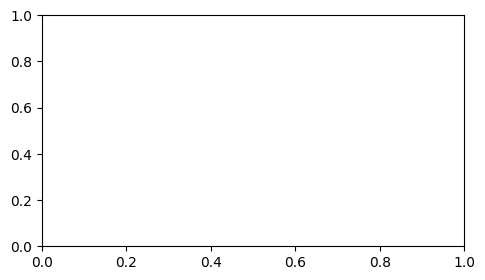

In [ ]:
plt.figure(figsize=(12, 3))
ax_one = plt.subplot(1, 2, 1)
plt.plot(metrics["loss"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_loss"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
ax_two = plt.subplot(1, 2, 2)
plt.plot(metrics["accuracy"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_accuracy"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.97      1.00      0.98      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
conf_mat = confusion_matrix(y_test,pred)
conf_mat

array([[ 969,    2,    1,    0,    0,    0,    3,    3,    2,    0],
       [   0, 1125,    2,    5,    0,    0,    0,    3,    0,    0],
       [   0,    0, 1026,    1,    0,    0,    0,    5,    0,    0],
       [   0,    1,    0, 1005,    0,    2,    0,    2,    0,    0],
       [   1,    0,    1,    0,  979,    0,    0,    0,    0,    1],
       [   0,    0,    0,    9,    0,  882,    1,    0,    0,    0],
       [   3,    2,    1,    0,    2,    2,  946,    0,    2,    0],
       [   0,    2,    6,    2,    1,    0,    0, 1014,    0,    3],
       [   1,    0,    1,    6,    0,    2,    0,    2,  959,    3],
       [   0,    0,    2,    3,    6,    4,    0,    5,    0,  989]])

<Axes: >

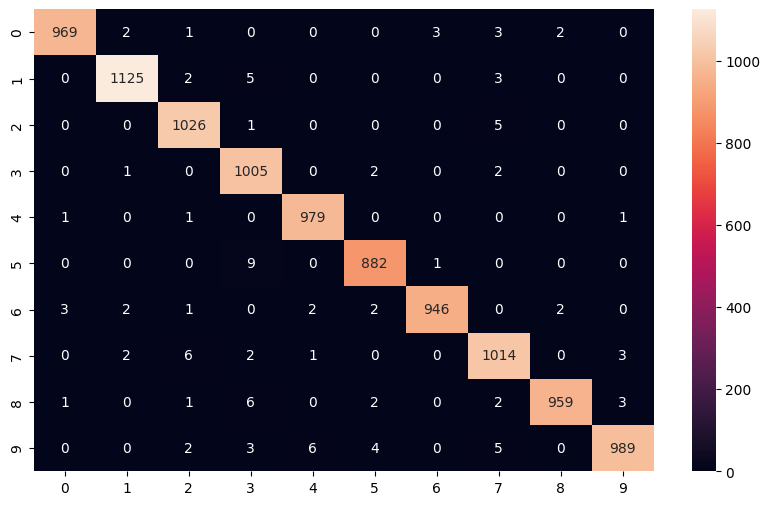

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(conf_mat,annot=True, fmt='g')

In [ ]:
misclf_img = [i for i, img in enumerate(y_test!=pred) if img==True]
len(misclf_img)

106

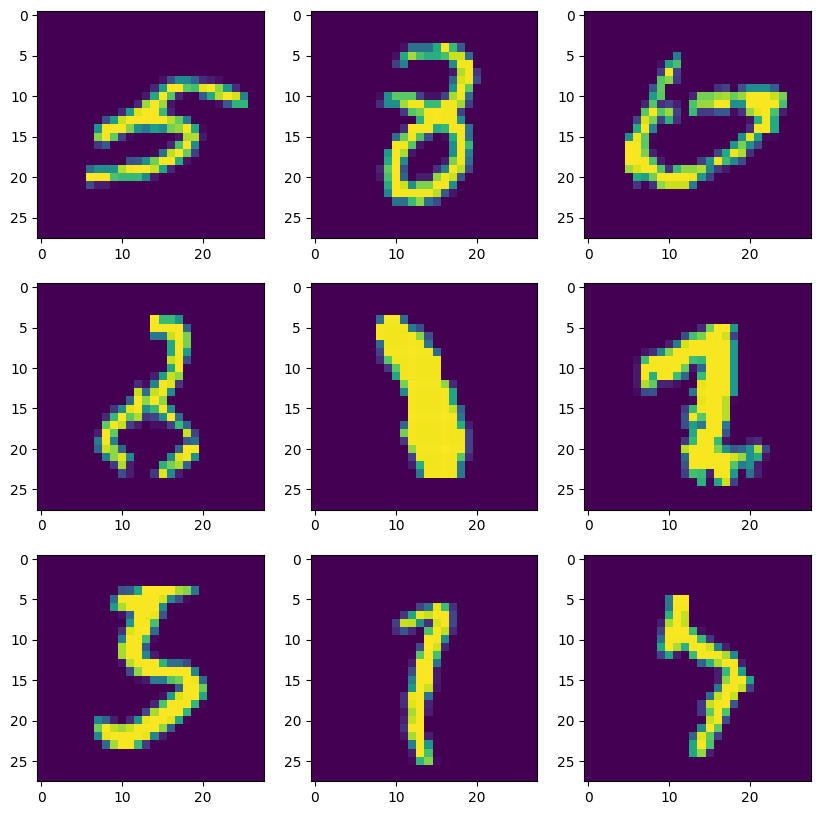


true_label [5, 8, 6, 8, 1, 2, 5, 1, 7]
wrong_pred [3, 3, 0, 2, 3, 7, 3, 7, 3]


In [ ]:
plt.figure(figsize=(10,10))
true_label = []
wrong_pred = []
for idx , num in enumerate(misclf_img[:9]):
  ax = plt.subplot(3,3,idx+1)
  plt.imshow(x_test[num])
  true_label.append(y_test[num])
  wrong_pred.append(pred[num])
plt.show()
print("\ntrue_label", true_label)
print("wrong_pred", wrong_pred)

### Fashion MNISt Date Base

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
print("x_train:", x_train.shape, type(x_train))
print("y_train:", y_train.shape, type(y_train))
print("x_test:", x_test.shape, type(x_test))
print("y_test:", y_test.shape, type(y_test))

x_train: (60000, 28, 28) <class 'numpy.ndarray'>
y_train: (60000,) <class 'numpy.ndarray'>
x_test: (10000, 28, 28) <class 'numpy.ndarray'>
y_test: (10000,) <class 'numpy.ndarray'>


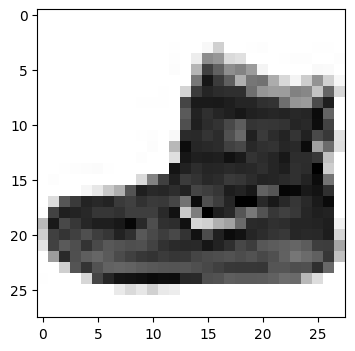

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(x_train[0], cmap="Greys")
plt.show()

In [ ]:
Counter(y_train)

Counter({9: 6000,
         0: 6000,
         3: 6000,
         2: 6000,
         7: 6000,
         5: 6000,
         1: 6000,
         6: 6000,
         4: 6000,
         8: 6000})

(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

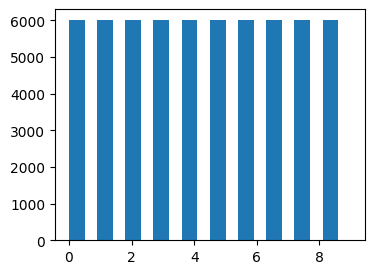

In [ ]:
plt.figure(figsize=(4,3))
plt.hist(y_train, bins=10, width=0.5)

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

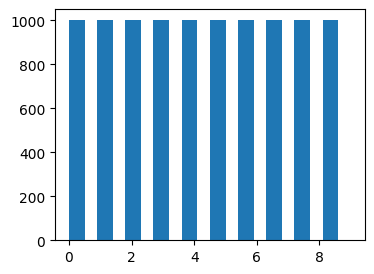

In [ ]:
plt.figure(figsize=(4,3))
plt.hist(y_test, bins=10, width=0.5)

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_train = x_train / 255.0
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_test = x_test / 255.0

In [ ]:
y_train_enc = to_categorical(y_train, num_classes=10)
y_test_enc = to_categorical(y_test, num_classes=10)

In [ ]:
def ConvNetBuilder():

  augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ], name="augmentation")

  inputs = layers.Input(shape=x_train.shape[1:], name="input_layer")
  feature = augmentation(inputs)
  feature = layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="first_convnet")(feature)
  feature = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="first_pool")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="second_convnet")(feature)
  feature = layers.AvgPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="second_pool")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="third_convnet")(feature)
  feature = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="third_pool")(feature)
  feature = layers.Flatten(name="flatten_layer")(feature)
  feature = layers.Dense(units=32, activation="relu", name="first_dense_layer")(feature)
  feature = layers.Dropout(rate=0.2, name="first_dropout_layer")(feature)
  outputs = layers.Dense(units=10, activation="softmax", name="output_layer")(feature)
  model = Model(inputs=inputs, outputs=outputs, name="ConvNet")
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                metrics=[Precision(), AUC(), "accuracy"])
  return model


In [ ]:
model = ConvNetBuilder()
model.summary()

Model: "ConvNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 augmentation (Sequential)   (None, 28, 28, 1)         0         
                                                                 
 first_convnet (Conv2D)      (None, 27, 27, 32)        160       
                                                                 
 first_pool (MaxPooling2D)   (None, 13, 13, 32)        0         
                                                                 
 second_convnet (Conv2D)     (None, 12, 12, 64)        8256      
                                                                 
 second_pool (AveragePoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                           

In [ ]:
callbacks_list = [EarlyStopping(monitor='loss', patience=3)]
monitor = model.fit(x=x_train, y=y_train_enc, validation_split=0.2,
          epochs=10, batch_size=128, callbacks=callbacks_list)

Epoch 1/10
375/375 [==============================] - 7s 8ms/step - loss: 1.3042 - precision: 0.7676 - auc: 0.9038 - accuracy: 0.5105 - val_loss: 0.7989 - val_precision: 0.8427 - val_auc: 0.9642 - val_accuracy: 0.6934
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 0.9206 - precision: 0.8103 - auc: 0.9521 - accuracy: 0.6558 - val_loss: 0.8296 - val_precision: 0.7903 - val_auc: 0.9599 - val_accuracy: 0.6882
Epoch 3/10
375/375 [==============================] - 3s 8ms/step - loss: 0.8325 - precision: 0.8207 - auc: 0.9605 - accuracy: 0.6839 - val_loss: 0.7534 - val_precision: 0.8020 - val_auc: 0.9668 - val_accuracy: 0.7060
Epoch 4/10
375/375 [==============================] - 3s 8ms/step - loss: 0.7838 - precision: 0.8287 - auc: 0.9648 - accuracy: 0.7037 - val_loss: 0.8039 - val_precision: 0.7777 - val_auc: 0.9621 - val_accuracy: 0.7104
Epoch 5/10
375/375 [==============================] - 2s 7ms/step - loss: 0.7434 - precision: 0.8301 - auc: 0.9681 - accuracy: 0

In [ ]:
metrics = pd.DataFrame(monitor.history)
metrics

,loss,precision,auc,accuracy,val_loss,val_precision,val_auc,val_accuracy
0,1.304161,0.767610,0.903841,0.510479,0.798930,0.842742,0.964238,0.693417
1,0.920594,0.810345,0.952079,0.655771,0.829570,0.790346,0.959921,0.688167
2,0.832457,0.820730,0.960512,0.683917,0.753403,0.801986,0.966826,0.706000
3,0.783841,0.828729,0.964778,0.703729,0.803925,0.777721,0.962147,0.710417
4,0.743432,0.830103,0.968147,0.719208,0.732556,0.806118,0.968326,0.732083
5,0.719202,0.829355,0.970052,0.729333,0.661849,0.820413,0.973642,0.759500
6,0.690347,0.832376,0.972288,0.741292,0.673798,0.805060,0.973242,0.743583
7,0.668254,0.836967,0.973967,0.749292,0.635318,0.819973,0.975733,0.763417
8,0.650810,0.839386,0.975133,0.757292,0.642051,0.811851,0.975320,0.762167
9,0.633506,0.842438,0.976328,0.765646,0.629214,0.813123,0.975862,0.767250


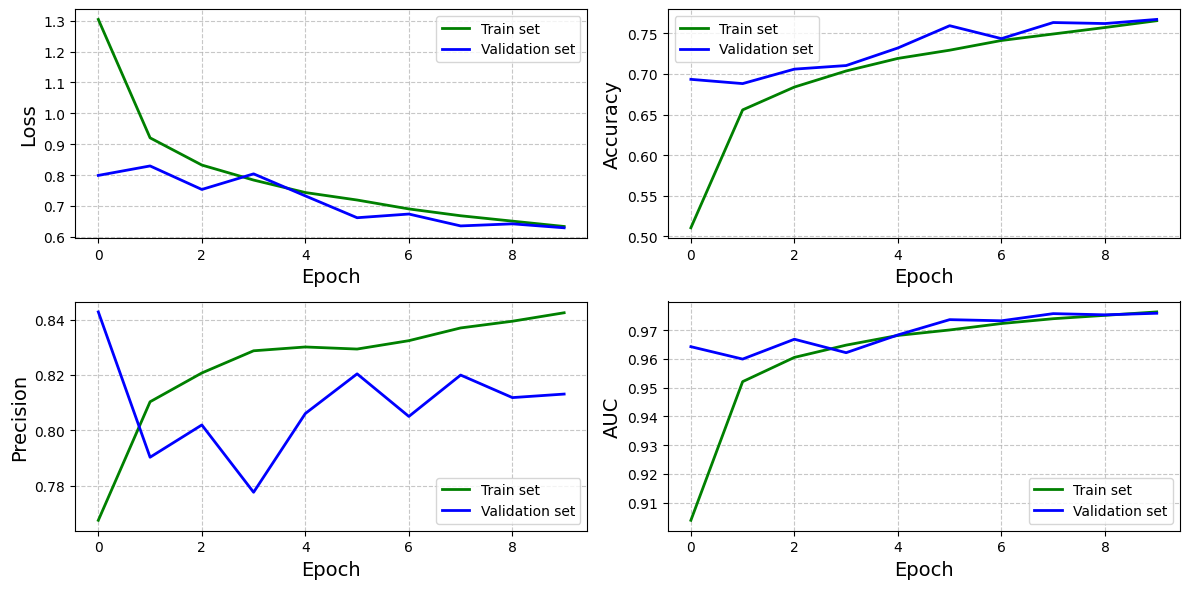

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(metrics["loss"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_loss"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 2)
plt.plot(metrics["accuracy"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_accuracy"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 3)
plt.plot(metrics["precision"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_precision"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Precision", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 4)
plt.plot(metrics["auc"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_auc"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("AUC", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [ ]:
pred = np.argmax(model.predict(x_test), axis=1)
print(classification_report(y_test, pred))
confusion_matrix(y_test, pred)

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1000
           1       0.97      0.95      0.96      1000
           2       0.70      0.73      0.71      1000
           3       0.82      0.75      0.79      1000
           4       0.65      0.56      0.60      1000
           5       0.73      0.96      0.83      1000
           6       0.45      0.56      0.50      1000
           7       0.92      0.64      0.76      1000
           8       0.91      0.94      0.92      1000
           9       0.93      0.91      0.92      1000

    accuracy                           0.77     10000
   macro avg       0.79      0.77      0.77     10000
weighted avg       0.79      0.77      0.77     10000



array([[738,   1,  47,  57,  18,   4, 110,   0,  25,   0],
       [  3, 951,   1,  23,  14,   0,   5,   0,   3,   0],
       [ 12,   1, 728,   6, 100,   0, 148,   0,   5,   0],
       [ 48,  20,  40, 752,  48,   8,  71,   1,  12,   0],
       [  2,   2,  82,  29, 558,   1, 315,   0,  11,   0],
       [  0,   0,   0,   6,   1, 964,   0,  12,  11,   6],
       [137,   1, 137,  38, 106,   0, 556,   0,  25,   0],
       [  0,   0,   0,   0,   0, 292,   0, 641,   1,  66],
       [  2,   0,  11,   1,  10,   5,  27,   5, 938,   1],
       [  0,   0,   0,   3,   1,  52,   1,  37,   1, 905]])

### Transfer Learning

#### Base Model

In [ ]:
os.getcwd()

'/content'

In [ ]:
working_dir = "/content/drive/MyDrive/DataSets/dogs-vs-cats"
os.listdir(working_dir)

['train', 'valid', 'test']

In [ ]:
os.chdir(working_dir)
assert os.getcwd() == working_dir

In [ ]:
train_dataset = image_dataset_from_directory(directory="train", labels='inferred', label_mode='int',
                                             color_mode='rgb', batch_size=32, image_size=(180, 180), shuffle=True)
validation_dataset = image_dataset_from_directory(directory="valid", labels='inferred', label_mode='int',
                                             color_mode='rgb', batch_size=32, image_size=(180, 180), shuffle=True)
test_dataset = image_dataset_from_directory(directory="test", labels='inferred', label_mode='int',
                                             color_mode='rgb', batch_size=32, image_size=(180, 180), shuffle=True)

Found 996 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
  print("data batch:", data_batch.shape, type(data_batch))
  print("labels batch:", labels_batch.shape, type(labels_batch))
  break

data batch: (32, 180, 180, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
labels batch: (32,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)>

In [ ]:
def CNN_Builder():
  augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ], name="augmentation")
  inputs = layers.Input(shape=(180, 180, 3), name="input_layer")
  feature = augmentation(inputs)
  feature = layers.Rescaling(1./255, name="rescale")(feature)
  feature = layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="first_convnet")(feature)
  feature = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="first_pool")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="second_convnet")(feature)
  feature = layers.AvgPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="second_pool")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="third_convnet")(feature)
  feature = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="third_pool")(feature)
  feature = layers.Flatten(name="flatten_layer")(feature)
  feature = layers.Dense(units=32, activation="relu", name="first_dense_layer")(feature)
  feature = layers.Dropout(rate=0.2, name="first_dropout_layer")(feature)
  outputs = layers.Dense(units=1, activation="sigmoid", name="output_layer")(feature)
  model = Model(inputs=inputs, outputs=outputs, name="ConvNet")
  model.compile(optimizer='rmsprop', loss='binary_crossentropy',
                metrics=["accuracy"])
  return model

In [ ]:
model = CNN_Builder()
model.summary()

Model: "ConvNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 180, 180, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescale (Rescaling)         (None, 180, 180, 3)       0         
                                                                 
 first_convnet (Conv2D)      (None, 179, 179, 32)      416       
                                                                 
 first_pool (MaxPooling2D)   (None, 89, 89, 32)        0         
                                                                 
 second_convnet (Conv2D)     (None, 88, 88, 64)        8256      
                                                                 
 second_pool (AveragePoolin  (None, 44, 44, 64)        0   

In [ ]:
callbacks_list = [EarlyStopping(monitor='loss', patience=3)]
monitor = model.fit(train_dataset, validation_data=validation_dataset,
                    epochs=100, callbacks=callbacks_list)

Epoch 1/100
32/32 [==============================] - 9s 160ms/step - loss: 0.7767 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 5s 130ms/step - loss: 0.6922 - accuracy: 0.5221 - val_loss: 0.7716 - val_accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 5s 112ms/step - loss: 0.6958 - accuracy: 0.5452 - val_loss: 0.7064 - val_accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 5s 148ms/step - loss: 0.6890 - accuracy: 0.5522 - val_loss: 0.6733 - val_accuracy: 0.6450
Epoch 5/100
32/32 [==============================] - 3s 73ms/step - loss: 0.6815 - accuracy: 0.5663 - val_loss: 0.6944 - val_accuracy: 0.5250
Epoch 6/100
32/32 [==============================] - 5s 101ms/step - loss: 0.6848 - accuracy: 0.5582 - val_loss: 0.7017 - val_accuracy: 0.5100
Epoch 7/100
32/32 [==============================] - 3s 73ms/step - loss: 0.6748 - accuracy: 0.5743 - val_loss: 0.7332 - val_accuracy: 0.5250
E

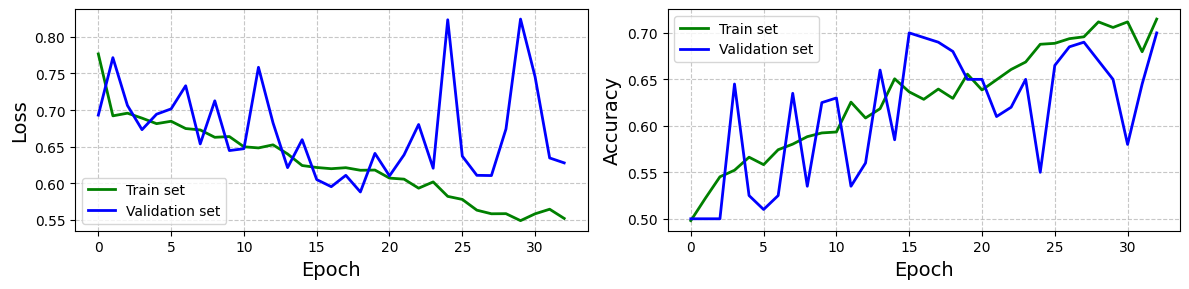

In [ ]:
performance = pd.DataFrame(monitor.history)
plt.figure(figsize=(12, 3))
ax_one = plt.subplot(1, 2, 1)
plt.plot(performance["loss"], label= "Train set", color='g', linewidth=2)
plt.plot(performance["val_loss"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
ax_two = plt.subplot(1, 2, 2)
plt.plot(performance["accuracy"], label= "Train set", color='g', linewidth=2)
plt.plot(performance["val_accuracy"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [ ]:
model.evaluate(test_dataset)

7/7 [==============================] - 40s 16ms/step - loss: 0.5145 - accuracy: 0.7500


[0.514456570148468, 0.75]

#### Feature Extraction Method

In [ ]:
conv_base = applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
def get_features_and_labels(dataset):
    features_list = []
    labels_list = []
    for images, labels in dataset:
        preprocessed_images = applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        features_list.append(features)
        labels_list.append(labels)
    return np.concatenate(features_list), np.concatenate(labels_list)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 19ms/step


In [ ]:
inputs = layers.Input(shape=train_features.shape[1:])
features = layers.Flatten()(inputs)
features = layers.Dense(128)(features)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(1, activation="sigmoid")(features)
model = Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1638528   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1638657 (6.25 MB)
Trainable params: 1638657 (6.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
monitor = model.fit(x=train_features, y=train_labels, epochs=20,
                    validation_data=(val_features, val_labels))

Epoch 1/20
32/32 [==============================] - 1s 10ms/step - loss: 12.0708 - accuracy: 0.9006 - val_loss: 2.0097 - val_accuracy: 0.9850
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 3.1580 - accuracy: 0.9719 - val_loss: 1.6005 - val_accuracy: 0.9850
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5276 - accuracy: 0.9970 - val_loss: 1.9830 - val_accuracy: 0.9900
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.8761 - accuracy: 0.9900 - val_loss: 1.9209 - val_accuracy: 0.9900
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5269 - accuracy: 0.9930 - val_loss: 3.0628 - val_accuracy: 0.9800
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0796 - accuracy: 0.9960 - val_loss: 2.1148 - val_accuracy: 0.9850
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0177 - accuracy: 0.9990 - val_loss: 3.2570 - val_accuracy: 0.9800
Epoch 8/20
32/32 [

In [ ]:
metrics = pd.DataFrame(monitor.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,12.070779,0.900602,2.009716,0.985
1,3.158040,0.971888,1.600495,0.985
2,0.527599,0.996988,1.983007,0.990
3,0.876149,0.989960,1.920938,0.990
4,0.526873,0.992972,3.062751,0.980


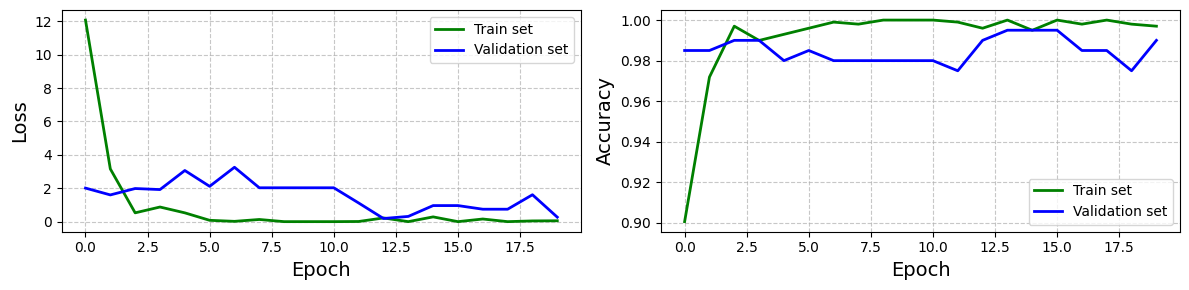

In [ ]:
plt.figure(figsize=(12, 3))
ax_one = plt.subplot(1, 2, 1)
plt.plot(metrics["loss"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_loss"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
ax_two = plt.subplot(1, 2, 2)
plt.plot(metrics["accuracy"], label= "Train set", color='g', linewidth=2)
plt.plot(metrics["val_accuracy"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [ ]:
model.evaluate(test_features, test_labels)

7/7 [==============================] - 0s 7ms/step - loss: 4.1771 - accuracy: 0.9650


[4.177138805389404, 0.9649999737739563]

#### Fine-tuning Method

In [1]:
for layer in conv_base.layers[:-4]:
    layer.trainable = False

NameError: name 'conv_base' is not defined

In [2]:
inputs = layers.Input(shape=(180, 180, 3))
features = applications.vgg16.preprocess_input(inputs)
features = conv_base(features)
features = layers.Flatten()(features)
features = layers.Dense(128)(features)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(1, activation="sigmoid")(features)
model = Model(inputs, outputs, name="vgg16_fine_tuned")
model.compile(loss="binary_crossentropy",
              optimizer= optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
model.summary()

NameError: name 'layers' is not defined

In [ ]:
monitor = model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

In [ ]:
y_test = np.array([])
pred = np.array([])
images = []

for batch_img, batch_label in test_dataset:
  y_test = np.concatenate([y_test, batch_label])
  pred  = np.concatenate([pred, model.predict(batch_img, verbose=0).reshape(-1,)])
  images.append(batch_img)

In [ ]:
test_images = np.concatenate(images)

In [ ]:
plt.hist(pred)
plt.show()

In [3]:
predictions = np.where(pred>0.5,1,0).reshape(-1,)

NameError: name 'np' is not defined

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
confusion_matrix(y_test,predictions)